### 

In [1]:
###Python Packages###

import numpy as np
import matplotlib.pyplot as plt
import math as mth
import timeit
import Double_Null_utils as dnu

###timer
start = timeit.default_timer()

In [2]:
###Initial Values###

M0=1.0#*0.0
Q=0.95#*0.0
N=30
scal=1
umax=12
vmax=20
ru0=5.0
dr0v=.40

bdytype="stan"
scalarfield=True

Elist=[1]

uloc=[0,1/4,1/2]

- $M_0$ is the initial mass
- $Q$ is the charge 
- $N$ is the number of points per coordinate (resolution)
- $scal$ increases the resolution for the boundary conditions
- $u_{max}$ is the max value for $u$ 
- $v_{max}$ is the max value for $v$ 
- $r_{u0}$ is the initial value $r(u_0,v_0)$
- $dr0v$ is the intial value $r_{,v}(u_0,v_0)$

- $bdytype$ indicates the type of boundary (standard "stan", horizon resolving "hor", maximal "max") 
- $scalarfield$ if $True$ applies a scalar field 
- $Elist$ allows the code to run for multiple resolutions $N'$. These resolutions are the arguments multiplied by $N$
- $uloc$ tells for which $v$ the code should plot (multplies $v_{max}$ to get $v$, values can range from $0$ to $1$)


In [3]:
###Defining Needed Constants###

scalf=float(scal)
u0=0.0
v0=0.0
rv0=ru0
phiu0=0.0
phiv0=0.0

if M0==0.0:
    du00=1/N
    du0=du00
else:
    du00=M0/N
    du0=du00
dv00=du00
dv0=du0

rplus=M0+(M0**2.0-Q**2.0)**.5
rminus=M0-(M0**2.0-Q**2.0)**.5
print("r+: "+str(rplus))
print("r-: "+str(rminus))

###Predicting Run time###

Nu=int(umax/du0)
Nv=int(vmax/dv0)
print("Number of points for lowest iteration is "+str(Nu*Nv)+","+str(Nu)+"X"+str(Nv))
print("Number of points for highest iteration is "+str(Nu*Nv*max(Elist)**2)+","+str(Nu*max(Elist))+"X"+str(Nv*max(Elist)))

numpoints=0.0
for i in range(0,len(Elist)):
    numpoints=Elist[i]**2.0*Nu*Nv+numpoints
    
print("Runtime: about "+str(numpoints/(38000*60))+" minutes")



r+: 1.31224989991992
r-: 0.6877501000800801
Number of points for lowest iteration is 216000,360X600
Number of points for highest iteration is 216000,360X600
Runtime: about 0.09473684210526316 minutes


The code predicts the runtime (based on an Intel i7-7700K CPU)

In [4]:
##################################
###Applying Boundary Conditions###

Emax=max([Elist])

rnpf=np.zeros((Nu*max(Elist),Nv*max(Elist),len(Elist)))
signpf=np.zeros((Nu*max(Elist),Nv*max(Elist),len(Elist)))
phinpf=np.zeros((Nu*max(Elist),Nv*max(Elist),len(Elist)))
dphinpuf=np.zeros((Nu*max(Elist),len(Elist)))

massnpf=np.zeros((Nu*max(Elist),Nv*max(Elist),len(Elist)))
temprnp=np.zeros((Nu*max(Elist),Nv*max(Elist)))
tempsignp=np.zeros((Nu*max(Elist),Nv*max(Elist)))
tempphinp=np.zeros((Nu*max(Elist),Nv*max(Elist)))
tempsignpu=np.zeros((Nu*max(Elist),Nv*max(Elist)))
tempphinpu=np.zeros((Nu*max(Elist)))


for k in range(0,len(Elist)):
    temprnp, tempsignp, tempphinp, tempsignpu, tempphinpu= dnu.boundary(scal,Elist[k],bdytype,Nu,Nv,ru0,dr0v,du0,vmax,M0,Q,scalarfield)
    for i in range(0,Nu*Elist[k]):
        for j in range(0,Nv*Elist[k]):
            rnpf[i][j][k]=temprnp[i][j]
            signpf[i][j][k]=tempsignp[i][j]
            phinpf[i][j][k]=tempphinp[i][j]
            dphinpuf[i][k]=tempphinpu[i]


Applies boundary conditions to empty arrays

In [5]:
drunp=np.zeros((Nu*max(Elist),Nv*max(Elist),len(Elist)))
dsigunp=np.zeros((Nu*max(Elist),Nv*max(Elist),len(Elist)))
drdvnplist=[]
drdvrlist=[]
dsigdvnplist=[]
dsigdvrlist=[]
rminuslist=[]
rminuslistv=[]
rpluslist=[]
rpluslistv=[]

###Applying Propagation Algorithm###
for k in range(0,len(Elist)):
    if bdytype=="max" or bdytype=="hor":
        drnpu=np.zeros((Nu*Elist[k])) 
        dsignpu=np.zeros((Nu*Elist[k]))
        sigu0=0.0
        drnpu[0]=-mth.exp(sigu0)/(4.0*dr0v)*(Q**2.0/ru0**2.0-2*M0/ru0+1.0)
        drnpu[1]=-mth.exp(sigu0)/(4.0*dr0v)*(Q**2.0/ru0**2.0-2*M0/ru0+1.0)
        sigmamaxlist=[]
        sigmaxu=[]
        sigmaxu.append(0.0)
        sigmaxu.append(0.0)
    for i in range(0,Nu*Elist[k]-1):
        for j in range(0,Nv*Elist[k]-1):
            answer=dnu.x4giver(i,j,Elist[k],k,du00,rnpf,phinpf,signpf,Q)
            rnpf[i+1][j+1][k]=answer[0]
            phinpf[i+1][j+1][k]=answer[1]
            signpf[i+1][j+1][k]=answer[2]
            massnpf[i+1][j+1][k]=answer[3]
            drunp[i+1][j+1][k]=answer[4]
            dsigunp[i+1][j+1]=answer[5]
            #dsignp[i+1][j+1]=answer[6]
            
            if bdytype=="hor" or bdytype=="max"  and i<Nu*Elist[k]-2:
                sigmamaxlist.append(signpf[i+1][j+1][k])
        if bdytype=="hor" and i<Nu*Elist[k]-2:
            
            sigma1=signpf[i+1][0][k]-signpf[i+1][-1][k]
            sigma2=signpf[i][0][k]-signpf[i][-1][k]
            sigma3=signpf[i-1][0][k]-signpf[i-1][-1][k]
            dt=(du00/Elist[k])
            
            signpf[i+2][0][k]=sigma1*(3.0*2.0)/(2.0)+sigma2*(3.0)/(-1.0)+sigma3*(2.0)/(2.0)
            
            dsignpu[i+1]=(signpf[i+2][0][k]-signpf[i+1][0][k])/dt
            rnpf[i+2][0][k]=rnpf[i+1][0][k]+dt*drnpu[i+1]
            
            drnpu[i+2]=drnpu[i+1]+dt*(drnpu[i+1]*dsignpu[i+1]-rnpf[i+1][0][k]*dphinpuf[i+1][k]**2.0)
            
        if bdytype=="max" and i<Nu*Elist[k]-2:
            
            sigmaxu.append(max(sigmamaxlist))
            sigma1=signpf[i+1][0][k]-sigmaxu[i+2]
            sigma2=signpf[i][0][k]-sigmaxu[i+1]
            sigma3=signpf[i-1][0][k]-sigmaxu[i]
            dt=(du00/Elist[k])
            
            signpf[i+2][0][k]=sigma1*(3.0*2.0)/(2.0)+sigma2*(3.0)/(-1.0)+sigma3*(2.0)/(2.0)
            dsignpu[i+1]=(signpf[i+2][0][k]-signpf[i+1][0][k])/dt
            rnpf[i+2][0][k]=rnpf[i+1][0][k]+dt*drnpu[i+1]
            drnpu[i+2]=drnpu[i+1]+dt*(drnpu[i+1]*dsignpu[i+1]-rnpf[i+1][0][k]*dphinpuf[i+1][k]**2.0)
            if rnpf[i+2][0][k]<0.0:
                signpf[i+2][0][k]=np.nan
                dsignpu[i+1]=np.nan
                rnpf[i+2][0][k]=np.nan
                drnpu[i+2]=np.nan
            
            sigmamaxlist=[]

In [6]:
###Rescaling to Standard Gauge###


stanscal=np.empty([Nu*Elist[-1],Nv*Elist[-1]])

if bdytype=="hor" or bdytype=="max":
    
    for k in range(0,len(Elist)):
        dt=du0/float(Elist[k])
        for i in range(0,Nu*Elist[k]-1):
            for j in range(0,Nv*Elist[k]-1):
                stanscal[i+1][j]=stanscal[i][j]+dt*mth.exp(signpf[i][j][-k])
            

In [7]:
if scalarfield==True:
    
    m=massnpf[1][-1][0]
    rplus=m+(m**2.0-Q**2.0)**.5
    rminus=m-(m**2.0-Q**2.0)**.5

If a scalar field is applied, the code estimates the new final horizons

In [8]:
###Finding Horizons###
           
for j in range(0,Nv*Elist[-1]):
    for i in range(0,Nu*Elist[-1]):
        if drunp[i][j][-1]>0.0:
            drdvnplist.append(i/(Nu*Elist[-1])*umax)
            drdvrlist.append(rnpf[i][j][-1])
            break
        if i==Nu*Elist[-1]-1:
            #drdvnplist.append(umax)
            #drdvrlist.append(rnpf[Nu*Elist[0]-1][j][0])
            drdvnplist.append(np.nan)
            drdvrlist.append(np.nan)
            #drdvnplist.append(nan)
            #drdvrlist.append(nan)
            break
        else:
            continue
            
for j in range(0,Nv*Elist[0]):
    for i in range(0,Nu*Elist[0]):
        if dsigunp[i][j][0]<0.0:
            dsigdvnplist.append(i/(Nu*Elist[0])*umax)
            dsigdvrlist.append(rnpf[i][j][0])
            #rpluslist.append(rplus)
            break 
        if i==Nu*Elist[0]-1:
            #drdvnplist.append(umax)
            #drdvrlist.append(rnpf[Nu*Elist[0]-1][j][0])
            dsigdvnplist.append(np.nan)
            dsigdvrlist.append(np.nan)
            #rpluslist.append(rplus)
            #drdvnplist.append(nan)
            #drdvrlist.append(nan)
            break
        else:
            continue       

Checks for an apparent horizon

In [9]:
###Defining u v Arrays for Plots###

urange=np.zeros((len(Elist),Nu*max(Elist)))
vrange=np.zeros((len(Elist),Nv*max(Elist)))
urange0=[]
vrange0=[]


for i in range(0,Nv*Elist[0]):
    rpluslist.append(rplus)
    rminuslist.append(rminus)

for k in range(0,len(Elist)):
    dt=du0/float(Elist[k])
    for i in range(0,Nu*Elist[k]):
        urange[k][i]=urange[k][i-1]+dt*mth.exp(signpf[i][0][k])
        if k==0:
            rminuslistv.append(rminus)
            rpluslistv.append(rplus)
            urange0.append(urange[0][i-1]+dt*mth.exp(signpf[i][0][0]))
for k in range(0,len(Elist)):
    dt=du0/float(Elist[k])
    for i in range(0,Nv*Elist[k]):
        vrange[k][i]=i*dt
        if k==0:
            vrange0.append(i*dt)

In [10]:
########################
###Displaying Results###       

rlist2=[]
siglist2=[]
diflist=[]
diflist2=[]
dudvlist=[]
uscale=[]
uvalue=u0
rlist=np.zeros((len(Elist),len(uloc),Nu*max(Elist)))
siglist=np.zeros((len(Elist),len(uloc),Nu*max(Elist)))
philist=np.zeros((len(Elist),len(uloc),Nu*max(Elist)))


for k in range(0,len(Elist)):
        for j in range(0,len(uloc)):
            for i in range(0,Nu*Elist[k]):
                rlist[k][j][i]=rnpf[i][int(uloc[j]*Nv*Elist[k])][k]
                siglist[k][j][i]=signpf[i][int(uloc[j]*Nv*Elist[k])][k]
                philist[k][j][i]=phinpf[i][int(uloc[j]*Nv*Elist[k])][k]

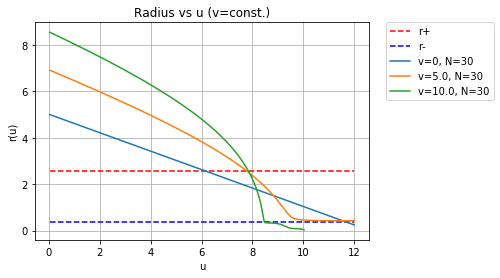

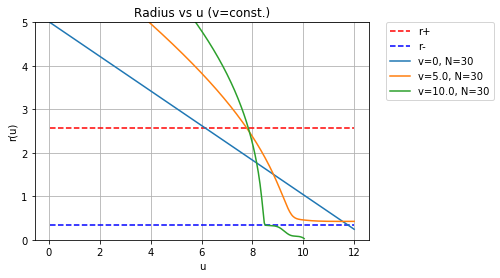

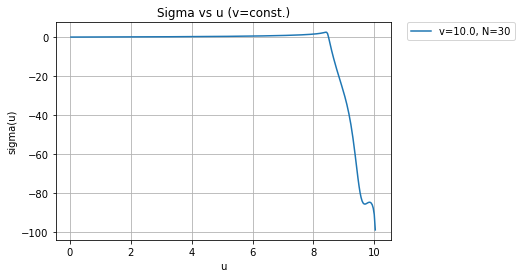

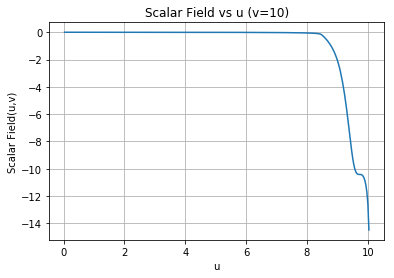

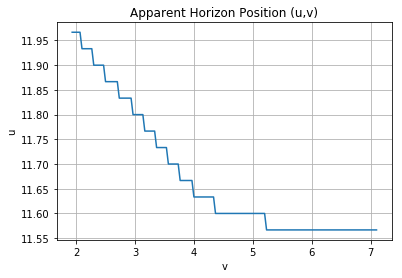

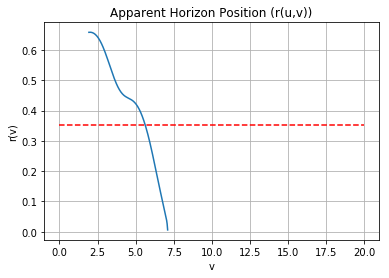

In [11]:
###Plotting Function vs u Graphs###
    
rplot=plt.plot(urange0, rpluslistv,'r--', label='r+')
rplot=plt.plot( urange0, rminuslistv,'r--',color='blue',label='r-') 
for k in range(0,len(Elist)):
    
    kmax=len(Elist)
    for j in range(0,len(uloc)):
        #plot=plt.plot(urange[kmax-k-1], rlist[kmax-k-1][j], label='v='+str(round(uloc[j ]*vmax,1))+', N='+str(N*Elist[kmax-k-1]))
        plot=plt.plot(urange[k], rlist[k][j], label='v='+str(round(uloc[j]*vmax,1))+', N='+str(N*Elist[k]))

plt.xlabel('u')
plt.ylabel('r(u)')
plt.legend()
plt.grid()
plt.title('Radius vs u (v=const.)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.tight_layout()
#plt.yscale('log')
plt.savefig('test2.png',dpi=300,bbox_inches="tight")
plt.show()



rplot=plt.plot(urange0, rpluslistv,'r--', label='r+')
if scalarfield==False and Q>0.0:
    rplot=plt.plot( urange0, rminuslistv,'r--',color='blue',label='r-')
    plt.xlim(8.0,14.0)    
    plt.ylim(0.0,2.0)
    #plt.xlim(6.0,12.0)
if scalarfield==True and Q>0.0:
    rplot=plt.plot( urange0, rminuslistv,'r--',color='blue',label='r-')    
    plt.ylim(0.0,5.0)
for k in range(0,len(Elist)):
    
    kmax=len(Elist)
    for j in range(0,len(uloc)):
        #plot=plt.plot(urange[kmax-k-1], rlist[kmax-k-1][j], label='v='+str(round(uloc[j ]*vmax,1))+', N='+str(N*Elist[kmax-k-1]))
        plot=plt.plot(urange[k], rlist[k][j], label='v='+str(round(uloc[j]*vmax,1))+', N='+str(N*Elist[k]))

plt.xlabel('u')
plt.ylabel('r(u)')
plt.legend()
plt.grid()
plt.title('Radius vs u (v=const.)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.tight_layout()
#plt.yscale('log')
plt.savefig('test2.5.png',dpi=300,bbox_inches="tight")
plt.show()



for k in range(0,len(Elist)):
    #sample2=plt.plot(urange[k],siglist[k][0],label='v='+str(uloc[0]*vmax)+', N='+str(N*Elist[k]))
    sample2=plt.plot(urange[k],siglist[k][-1],label='v='+str(uloc[-1]*vmax)+', N='+str(N*Elist[k]))
    #sample2.set_yscale('log')
#sample=plt.plot(uscale, siglist)
plt.xlabel('u')
plt.ylabel('sigma(u)')

if M0==0.0 or Q==0.0 or M0==1.0:
    plt.yscale('linear')
else:
    plt.yscale('log')
plt.grid()
plt.title('Sigma vs u (v=const.)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('test3.png',dpi=300,bbox_inches="tight")
plt.show()

sample3=plt.plot(urange[-1],philist[-1][-1])
plt.xlabel('u')
plt.ylabel('Scalar Field(u,v)')
plt.grid()
plt.title('Scalar Field vs u (v='+str(int(uloc[-1]*vmax))+')')
plt.savefig('test6.png',dpi=300,bbox_inches="tight")
plt.show()

sample3=plt.plot(vrange[-1],drdvnplist)
plt.xlabel('v')
plt.ylabel('u')
plt.grid()
plt.title('Apparent Horizon Position (u,v)')
#plt.savefig('Event Horizon Position(u,v)-M=1-Q=.09-N=200.png',dpi=300)
plt.show()



sample3=plt.plot(vrange[-1],drdvrlist)
sample3=plt.plot(vrange0,rminuslist,'r--')
plt.xlabel('v')
plt.ylabel('r(v)')
plt.grid()
plt.title('Apparent Horizon Position (r(u,v))')
plt.savefig('test7.png',dpi=300)
plt.show()


rnp=np.empty([Nu*Elist[-1],Nv*Elist[-1]])
signp=np.empty([Nu*Elist[-1],Nv*Elist[-1]])
phinp=np.empty([Nu*Elist[-1],Nv*Elist[-1]])
massnp=np.empty([Nu*Elist[-1],Nv*Elist[-1]])

for i in range(0,Nu*Elist[-1]): 
    for j in range(0,Nv*Elist[-1]):
        rnp[i][j]=rnpf[i][j][-1]
        signp[i][j]=signpf[i][j][-1]
        phinp[i][j]=phinpf[i][j][-1]
        massnp[i][j]=massnpf[i][j][-1]

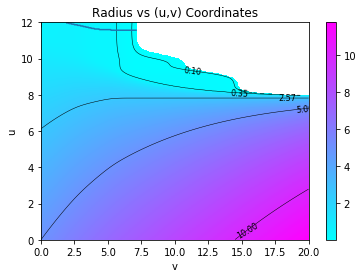

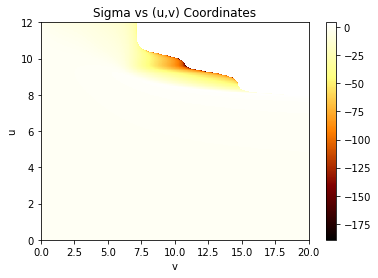

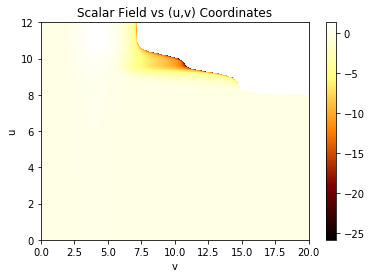

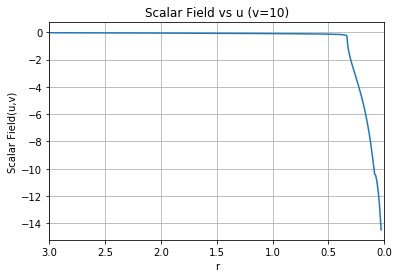

7.236360954463779 seconds
0.12060601590772964 minutes
0.0020101002651288272 hours
29849.257293717434 points per second


In [12]:
###Heatmaps for radius, sigma, scalar field###

levels=np.arange(10.0, np.nanmax(rnp), 5.0 )


if rplus==0.0:
    levels=np.insert(levels,0,[ru0])
if rminus==0.0 and rplus>0.0 and scalarfield==False:
    levels=np.insert(levels,0,[0.1,rplus,ru0])
if scalarfield==True and Q==0.0:
    levels=np.insert(levels,0,[0.1,rplus,ru0])
if scalarfield==True and Q>0.0:
    levels=np.insert(levels,0,[0.1,rminus,rplus,ru0])
if scalarfield==False and Q>0.0:
    levels=np.insert(levels,0,[rminus,rplus,ru0])

plot1=plt.imshow(rnp,cmap=plt.cm.cool,extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plot4=plt.contour(rnp, levels,linewidths=0.5,colors='black',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plt.clabel(plot4, levels,  
           inline=0, inline_spacing=0, 
           fmt='%1.2f',rightside_up=True,
           fontsize=8)
sample3=plt.plot(vrange[-1],drdvnplist)
#sample3=plt.plot(vrange,dsigdvnplist)
plt.xlabel('v')
plt.ylabel('u')
plt.xlim()
plt.colorbar(plot1)
plt.title('Radius vs (u,v) Coordinates')
plt.savefig('Test.png',dpi=300)
plt.show()

plot3=plt.imshow(signp,cmap=plt.cm.afmhot,extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plt.xlabel('v')
plt.ylabel('u')
plt.colorbar(plot3)
plt.title('Sigma vs (u,v) Coordinates')
plt.savefig('test4.png',dpi=300,bbox_inches="tight")
plt.show()

plot2=plt.imshow(phinp,cmap=plt.cm.afmhot,extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plt.xlabel('v')
plt.ylabel('u')
plt.colorbar(plot2)
plt.title('Scalar Field vs (u,v) Coordinates')
plt.show()

sample3=plt.plot(rlist[-1][-1],philist[-1][-1])
plt.xlabel('r')
plt.ylabel('Scalar Field(u,v)')
plt.xlim(3.0,0.0)
plt.grid()
plt.title('Scalar Field vs u (v='+str(int(uloc[-1]*vmax))+')')
plt.savefig('test5.png',dpi=300,bbox_inches="tight")
plt.show()

stop = timeit.default_timer()

print(str(stop - start)+' seconds')
print(str((stop - start)/60)+' minutes')
print(str((stop - start)/3600)+' hours')

print(str((numpoints)/(stop - start))+' points per second')
